# Emotion Classification 

Classifiy different emotion based on different labeled emotion images. The task is to build a machine learning model that can classify the emotional connotation behind tweets into categories such as joy, sadness, anger, or fear. This process involves data preprocessing, model development, evaluation, and analysis of the model's performance.


In [87]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import emoji

from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from autocorrect import Speller
import re


#Modelling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dropout, Dense, BatchNormalization, Conv1D, GlobalMaxPooling1D, MaxPooling1D 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2    # regularization to prevent over fiting
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sheyi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sheyi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Loading the Dataset

In [3]:
# Load Dataset
train_data = pd.read_csv('emotion-labels-train.csv')
val_data = pd.read_csv('emotion-labels-val.csv')
test_data = pd.read_csv('emotion-labels-test.csv')
train_data.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [4]:
val_data.head()

,text,label
0,"@theclobra lol I thought maybe, couldn't decid...",joy
1,Nawaz Sharif is getting more funnier than @kap...,joy
2,Nawaz Sharif is getting more funnier than @kap...,joy
3,@tomderivan73 😁...I'll just people watch and e...,joy
4,I love my family so much #lucky #grateful #sma...,joy


In [5]:
test_data.head()

,text,label
0,You must be knowing #blithe means (adj.) Happ...,joy
1,Old saying 'A #smile shared is one gained for ...,joy
2,Bridget Jones' Baby was bloody hilarious 😅 #Br...,joy
3,@Elaminova sparkling water makes your life spa...,joy
4,I'm tired of everybody telling me to chill out...,joy


### Analyse the Dataset

In [6]:
# Analyse and Describe Dataset
print('Train Dataset Info')
train_data.info()
print('\nValidation Dataset Info')
val_data.info()
print('\nTest Dataset Info')
test_data.info()

Train Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3613 entries, 0 to 3612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3613 non-null   object
 1   label   3613 non-null   object
dtypes: object(2)
memory usage: 56.6+ KB

Validation Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    347 non-null    object
 1   label   347 non-null    object
dtypes: object(2)
memory usage: 5.6+ KB

Test Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3142 non-null   object
 1   label   3142 non-null   object
dtypes: object(2)
memory usage: 49.2+ KB


In [7]:
# Preprocess dataset
# check for duplicates
duplicate_train = train_data.duplicated().sum()
print('Number of Duplicate in Train Dataset =', duplicate_train)

duplicate_test = test_data.duplicated().sum()
print('Number of Duplicate in Train Dataset =', duplicate_test)

duplicate_val = val_data.duplicated().sum()
print('Number of Duplicate in Train Dataset = ', duplicate_val)

Number of Duplicate in Train Dataset = 0
Number of Duplicate in Train Dataset = 0
Number of Duplicate in Train Dataset =  0


In [8]:
# check for duplicates

print('Number of Null in Train Dataset \n', train_data.isnull().sum())


print('Number of Null in Train Dataset \n',  test_data.isnull().sum())


print('Number of Null in Train Dataset \n', val_data.isnull().sum())

Number of Null in Train Dataset 
 text     0
label    0
dtype: int64
Number of Null in Train Dataset 
 text     0
label    0
dtype: int64
Number of Null in Train Dataset 
 text     0
label    0
dtype: int64


### Separate Dataset into Features and Labels

In [9]:
# Separate Dataset into features and labels

X_train = train_data['text']
y_train = train_data['label']
X_val = val_data['text']
y_val = val_data['label']
X_test = test_data['text']
y_test = test_data['label']

X_train.head()

0    Just got back from seeing @GaryDelaney in Burs...
1    Oh dear an evening of absolute hilarity I don'...
2    Been waiting all week for this game ❤️❤️❤️ #ch...
3    @gardiner_love : Thank you so much, Gloria! Yo...
4    I feel so blessed to work with the family that...
Name: text, dtype: object

### Encode the Dataset Label

In [10]:
# Encode the label
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train) # train
y_val_encoded = label_encoder.transform(y_val)         # accurately predict
y_test_encoded = label_encoder.transform(y_test)

y_train_encoded[:5]

array([2, 2, 2, 2, 2])

### Reshape the Feature

In [11]:
# Reshape labels for model input
y_train_encoded = y_train_encoded.reshape(-1, 1)
y_val_encoded = y_val_encoded.reshape(-1, 1)
y_test_encoded = y_test_encoded.reshape(-1, 1)

y_train_encoded[:5]

array([[2],
       [2],
       [2],
       [2],
       [2]])

### Label Classes and Encoded values

In [12]:
# Check the mapping of labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'anger': 0, 'fear': 1, 'joy': 2, 'sadness': 3}


## Visualize the Train Data Labels


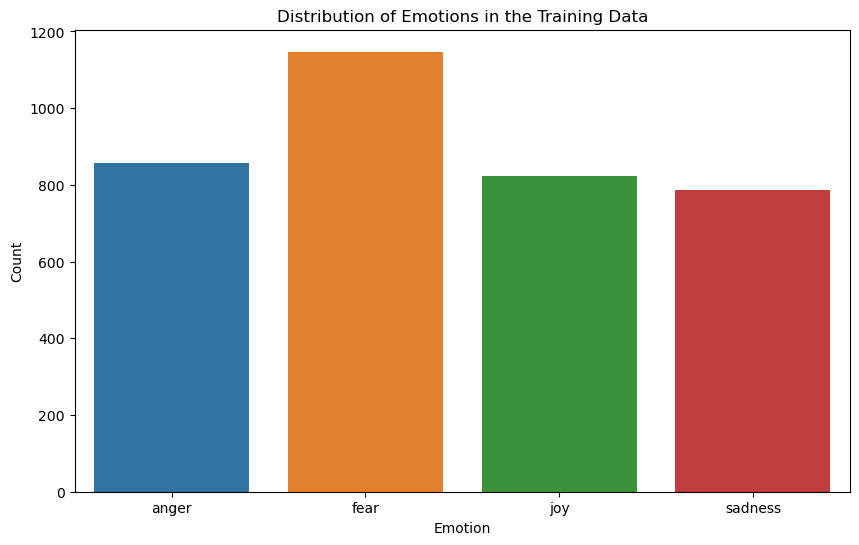

In [13]:
# Plot the distribution of emotions in the training data
plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_mapping.values()), y=[(y_train_encoded == i).sum() for i in range(len(label_mapping))])
plt.xticks(ticks=list(label_mapping.values()), labels=list(label_mapping.keys()))
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions in the Training Data')
plt.show()

## Text Preprocessing
Tokenize the text.
Correct spelling mistakes using the autocorrect library.
Remove stopwords.
Use PorterStemmer or WordNetLemmatizer.
Clean the text with regular expressions.

In [19]:
# Initialize the spell checker and stemmer
spell = Speller()
stemmer = PorterStemmer()

# Define a function for text preprocessing
def preprocess_text(text):
   
    # Convert text to lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove @mentions
    text = re.sub(r'@\S+', '', text)
    
    # Remove emojis using the emoji library
    text = emoji.replace_emoji(text, replace='')
    
    # Tokenize the text
    tokens = word_tokenize(text)

    # Correct spelling errors in tokens
    tokens = [spell(word) for word in tokens]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    
    # Stem the words
    tokens = [stemmer.stem(word) for word in tokens]
    
    return tokens

In [20]:
# Apply preprocessing to the tweets
X_train_processed = X_train.apply(preprocess_text)
X_val_processed = X_val.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)

# Print the first few processed tweets
print(X_train_processed.head())

0    [got, back, see, garydelaney, burslem, amaz, f...
1    [oh, dear, even, absolut, clariti, dont, think...
2                    [wait, week, game, cheer, friday]
3    [gardinerlov, thank, much, gloria, your, sweet...
4    [feel, bless, work, famili, nanni, noth, love,...
Name: text, dtype: object


In [21]:
X_train['processed_text'] = X_train_processed
X_val['processed_text'] = X_val_processed
X_test['processed_text'] = X_test_processed
print(X_train.head())

0    Just got back from seeing @GaryDelaney in Burs...
1    Oh dear an evening of absolute hilarity I don'...
2    Been waiting all week for this game ❤️❤️❤️ #ch...
3    @gardiner_love : Thank you so much, Gloria! Yo...
4    I feel so blessed to work with the family that...
Name: text, dtype: object


### Histogram of Sequence Lengths

In [23]:
# Calculate the length of each tweet
train_lengths = X_train_processed.apply(len)
val_lengths = X_val_processed.apply(len)
test_lengths = X_test_processed.apply(len)
train_lengths

0       12
1       11
2        5
3       11
4       11
        ..
3608    11
3609     3
3610    12
3611    10
3612    18
Name: text, Length: 3613, dtype: int64

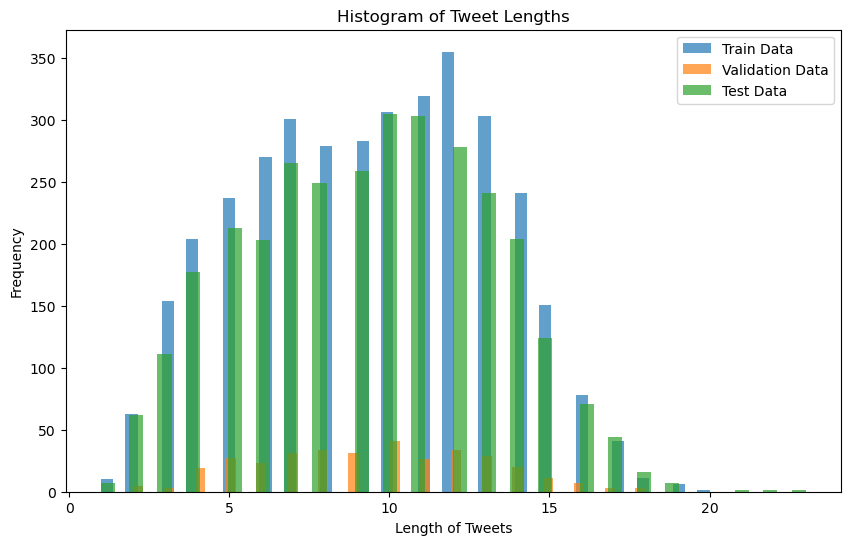

In [24]:
# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=50, alpha=0.7, label='Train Data')
plt.hist(val_lengths, bins=50, alpha=0.7, label='Validation Data')
plt.hist(test_lengths, bins=50, alpha=0.7, label='Test Data')
plt.xlabel('Length of Tweets')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Tweet Lengths')
plt.show()

## Data Tokenizer & Padding

In [30]:
# Check basic statistics for tweet lengths
print(f'Min length: {train_lengths.min()}')
print(f'Max length: {train_lengths.max()}')
print(f'Mean length: {train_lengths.mean()}')
print(f'Median length: {train_lengths.median()}')

# Set max_len to a value that covers most of the tweet lengths
max_len = int(train_lengths.quantile(0.95))  # Set to the 95th percentile
print(f'Sequence length (max_len) set to: {max_len}')

Min length: 1
Max length: 20
Mean length: 9.35206199833933
Median length: 10.0
Sequence length (max_len) set to: 15


In [31]:
# Build the model and display summary

embedding_dim = 100
vocab_size = 5000
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size)

# Fit the tokenizer on the training data
tokenizer.fit_on_texts(X_train_processed)

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train_processed)
X_val_seq = tokenizer.texts_to_sequences(X_val_processed)
X_test_seq = tokenizer.texts_to_sequences(X_test_processed)

# Apply padding to make sequences of equal length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [32]:
# Get the number of unique words (vocabulary size)
unique_words = len(tokenizer.word_index) + 1  # +1 because word_index starts at 1
print(f'Number of unique words in training data: {unique_words}')

Number of unique words in training data: 7492


In [117]:
# Check the shapes of the padded sequences
print(f"\n\nTrain Padded Shape: {X_train_pad.shape}")
print(f"Validation Padded Shape: {X_val_pad.shape}")
print(f"Test Padded Shape: {X_test_pad.shape}\n\n")


# Check the tokenized text of the first tweet to ensure it looks as expected
print(f"Tokenized Text (First tweet):\n {X_train_seq[0]}")
print(f"Padded Text (First tweet):\n {X_train_pad[0]}")



Train Padded Shape: (3613, 15)
Validation Padded Shape: (347, 15)
Test Padded Shape: (3142, 15)


Tokenized Text (First tweet):
 [29, 37, 30, 2140, 2141, 49, 89, 28, 354, 110, 55, 129]
Padded Text (First tweet):
 [  29   37   30 2140 2141   49   89   28  354  110   55  129    0    0
    0]


## Tokenized Word Mapping

In [34]:
tokenizer.word_index

{'im': 1,
 'like': 2,
 'get': 3,
 'dont': 4,
 'amp': 5,
 'go': 6,
 'make': 7,
 'day': 8,
 'one': 9,
 'watch': 10,
 'live': 11,
 'love': 12,
 'time': 13,
 'know': 14,
 'feel': 15,
 'peopl': 16,
 'good': 17,
 'think': 18,
 'want': 19,
 'happi': 20,
 'need': 21,
 'start': 22,
 'cant': 23,
 'u': 24,
 'look': 25,
 'would': 26,
 'sad': 27,
 'still': 28,
 'got': 29,
 'see': 30,
 'terror': 31,
 'let': 32,
 'today': 33,
 'way': 34,
 'cheer': 35,
 'say': 36,
 'back': 37,
 'play': 38,
 'realli': 39,
 'lost': 40,
 'life': 41,
 'never': 42,
 'even': 43,
 'fuck': 44,
 'smile': 45,
 'fear': 46,
 'work': 47,
 'alway': 48,
 'amaz': 49,
 'music': 50,
 'thing': 51,
 'someon': 52,
 'thank': 53,
 'depress': 54,
 'much': 55,
 'right': 56,
 'come': 57,
 'use': 58,
 'take': 59,
 'rage': 60,
 'give': 61,
 'na': 62,
 'your': 63,
 'new': 64,
 'tri': 65,
 'ever': 66,
 'broadcast': 67,
 'angri': 68,
 'horror': 69,
 'lol': 70,
 'guy': 71,
 'ive': 72,
 'anger': 73,
 'week': 74,
 'first': 75,
 'man': 76,
 'year': 77,

In [36]:
# Vocabulary size: Use either the size of unique words or a specific limit
print(vocab_size)

# Maximum sequence length: Set based on tweet length distribution
print(max_len)   

# Dimensionality of word embeddings
print(embedding_dim)

5000
15
100


## Modelling
#### bidirectional LSTM Model

In [ ]:
# Build the model
model = Sequential()

# Add Embedding layer with correct input_dim and input_length
# We explicitly define the input_shape for the first layer, this helps TensorFlow to initialize the parameters correctly
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# Add Bidirectional LSTM layer with correct input shape
model.add(Bidirectional(LSTM(128, return_sequences=True)))

# Add Dropout layer
model.add(Dropout(0.3))

# Add another LSTM layer
model.add(LSTM(64))

# Add another Dropout layer
model.add(Dropout(0.3))

# Add Dense layer with 4 output classes (for classification)
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
# Display the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 15, 100)             │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 15, 256)             │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,450,798 (9.35 MB)

 Trainable params: 816,932 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,633,866 (6.23 MB)

In [39]:
# Train the model with train and validation set
# Train the model
history = model.fit(X_train_pad, y_train_encoded, epochs=10, batch_size=64, validation_data=(X_val_pad, y_val_encoded))

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.3329 - loss: 1.3439 - val_accuracy: 0.5994 - val_loss: 1.0293
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7874 - loss: 0.5538 - val_accuracy: 0.6599 - val_loss: 0.9165
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9249 - loss: 0.2383 - val_accuracy: 0.6715 - val_loss: 1.1178
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9558 - loss: 0.1549 - val_accuracy: 0.7118 - val_loss: 1.0027
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9697 - loss: 0.1104 - val_accuracy: 0.7032 - val_loss: 1.1370
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9802 - loss: 0.0822 - val_accuracy: 0.6888 - val_loss: 1.3187
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9753 - loss: 0.0886 - val_accuracy: 0.7032 - val_loss: 1.2567
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9688 - loss: 0.1042 - val_accuracy: 0.7032 - 

In [ ]:
# Display Model Evaluation (accuracy and confusion matrix) on train
def make_prediction(model, data, labels, title):
    y_pred = model.predict(data)
    y_pred = y_pred.argmax(axis=1)

    # Calculate accuracy on test data
    accuracy = (y_pred == labels.flatten()).mean()
    print(f"{title} Accuracy: {accuracy:.4f}/n")

    
    # Confusion Matrix
    cm = confusion_matrix(labels, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
    plt.title(f'Confusion Matrix for {title} Data')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
# Training History Plot (Accuracy and Loss)
def model_accuracy_and_loss(history):
    plt.figure(figsize=(12, 6))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Validation Accuracy: 0.6859/n


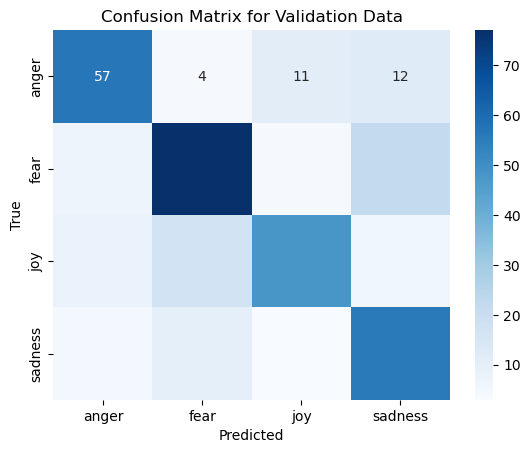

In [54]:
# Predict on validation data
make_prediction(model, X_val_pad, y_val_encoded, "Validation")

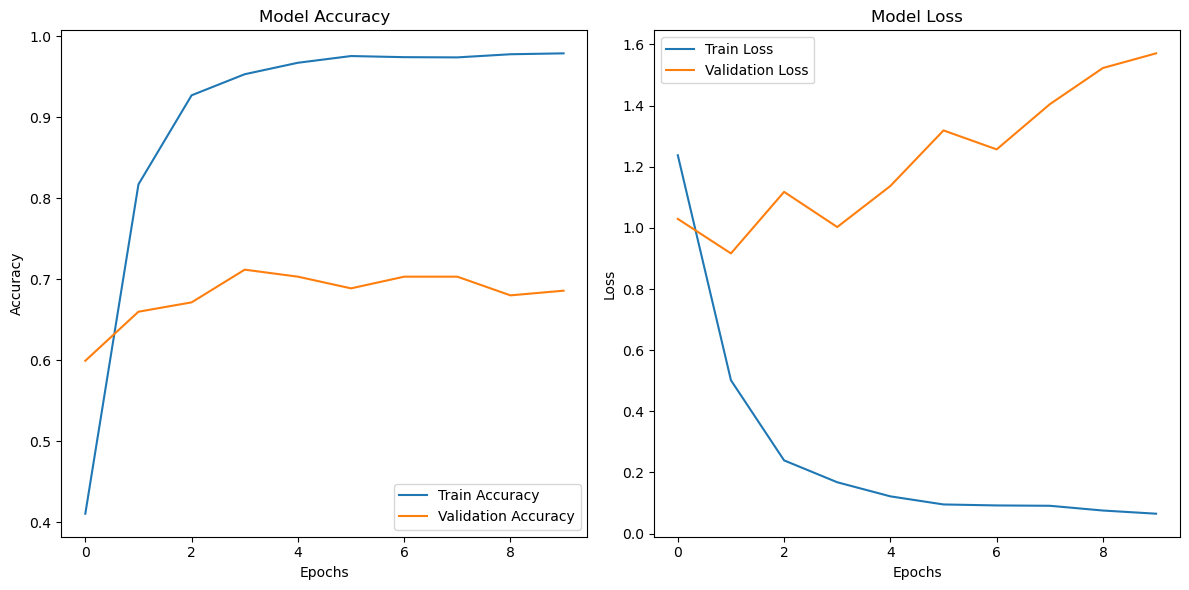

In [55]:
# Model accuracy and loss
model_accuracy_and_loss(history)

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Test Accuracy: 0.6779/n


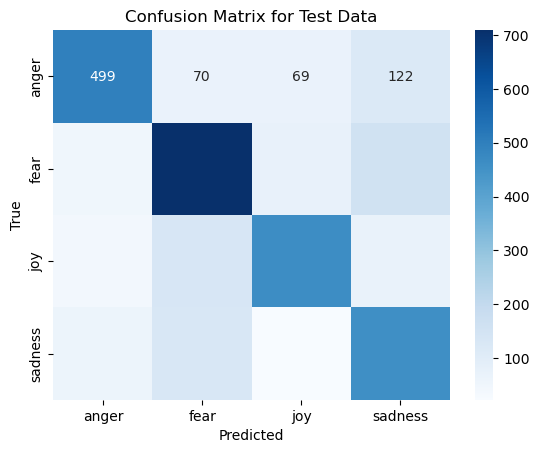

In [43]:
#Predict the Test Data Set
# Predict on Test data
make_prediction(model, X_test_pad, y_test_encoded, "Test")

## Explanation and Observation for the First Model

there seems to be some high level of overfitting and and an increase on the validation loss with is not appropraite

## Create Another Model with more layers and hyper parameters (LSTM and GRU)

In [ ]:
# Build a deeper and more complex model
model_2 = Sequential()

# Embedding Layer
model_2.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len))

# Bidirectional LSTM Layer
model_2.add(Bidirectional(LSTM(128, return_sequences=True)))
model_2.add(Dropout(0.3))

# GRU Layer
model_2.add(GRU(64, dropout=0.2))

# Dense Hidden Layer with Batch Normalization
model_2.add(Dense(128, activation='relu'))
model_2.add(BatchNormalization())

# Dropout after Dense layer
model_2.add(Dropout(0.3))

# Output Layer (4 classes)
model_2.add(Dense(4, activation='softmax'))  # 4 output classes: joy, sadness, anger, fear

# Compile the model
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [51]:
# Summary of the model
model_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 15, 100)             │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 15, 256)             │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          61,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,416,494 (9.22 MB)

 Trainable params: 805,412 (3.07 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 1,610,826 (6.14 MB)

In [48]:
# Initialize EarlyStopping to monitor validation accuracy and stop early if the performance doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history_2 = model_2.fit(X_train_pad, y_train_encoded, epochs=10, batch_size=64, 
                        validation_data=(X_val_pad, y_val_encoded), 
                        callbacks=[early_stopping])

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.3348 - loss: 1.3424 - val_accuracy: 0.3429 - val_loss: 1.3029
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8710 - loss: 0.3816 - val_accuracy: 0.5994 - val_loss: 1.1617
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9511 - loss: 0.1640 - val_accuracy: 0.7061 - val_loss: 0.9836
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9710 - loss: 0.1025 - val_accuracy: 0.7493 - val_loss: 0.8202
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9766 - loss: 0.0824 - val_accuracy: 0.7493 - val_loss: 0.7558
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9794 - loss: 0.0732 - val_accuracy: 0.7406 - val_loss: 0.8068
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9795 - loss: 0.0648 - val_accuracy: 0.7406 - val_loss: 0.8283
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9816 - loss: 0.0625 - val_accuracy: 0.7349 - 

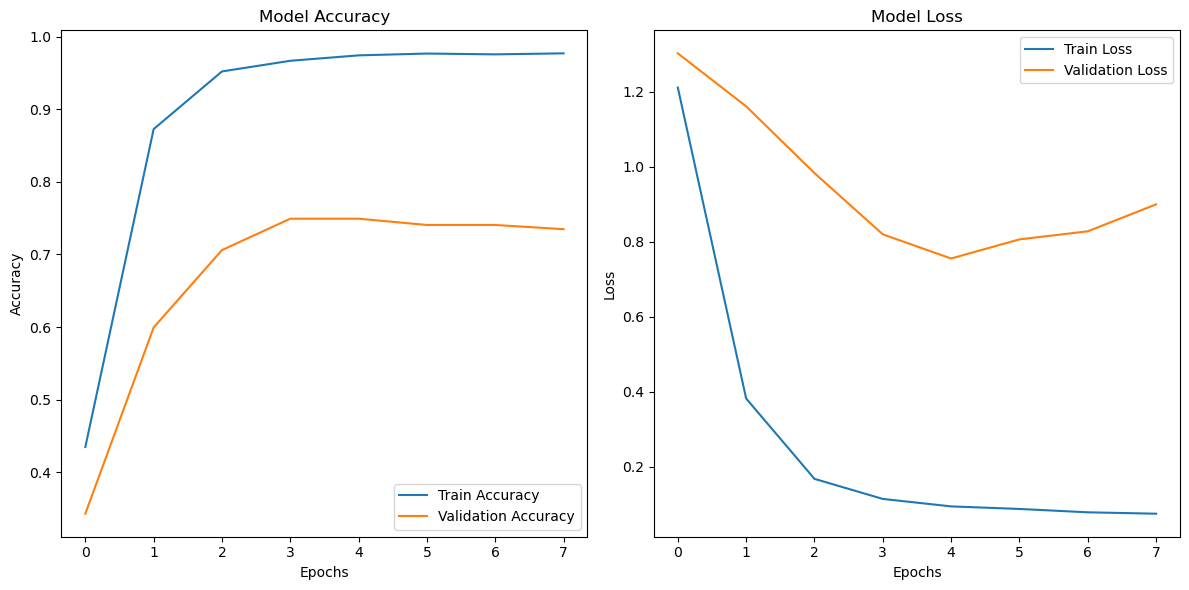

In [50]:

# Model 2 accuracies and loss
model_accuracy_and_loss(history_2)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step
Validation Accuracy: 0.7493/n


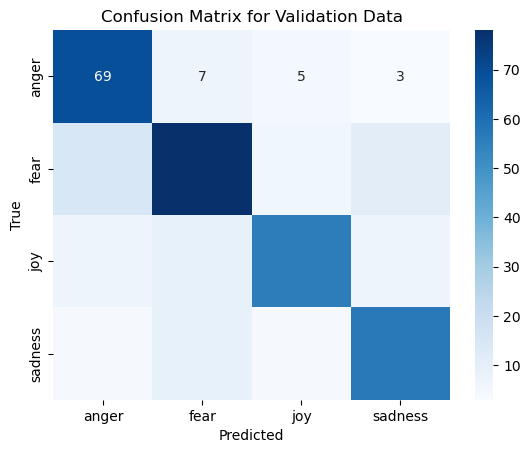

In [52]:
# Predict on Test data
make_prediction(model_2, X_val_pad, y_val_encoded, "Validation")

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Test Accuracy: 0.7467/n


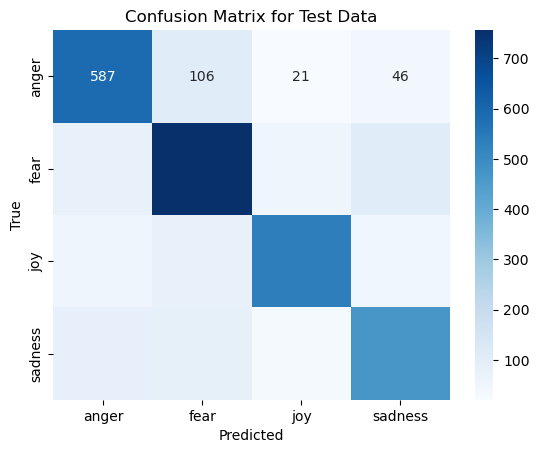

In [53]:
# Predict on Test data
make_prediction(model_2, X_test_pad, y_test_encoded, "Test")

## Another Model
### Base Model with LSTM and Dense Layers and learning_rate=0.001

Trying to use less parameters and see if the we can still achieve the same performance

In [57]:
# Model 1: Simple LSTM model
model_3 = Sequential()

# Embedding layer
model_3.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# LSTM Layer
model_3.add(LSTM(64))

# Dropout to avoid overfitting
model_3.add(Dropout(0.5))

# Dense output layer for binary classification
model_3.add(Dense(num_classes, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model_3.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_binary_crossentropy', metrics=['accuracy'])

In [61]:
# Model summary
model_3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (32, 15, 100)               │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (32, 64)                    │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (32, 4)                     │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 542,500 (2.07 MB)

 Trainable params: 542,500 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Train the model
history_3 = model.fit(X_train_pad, y_train_encoded, epochs=10, batch_size=64, validation_data=(X_val_pad, y_val_encoded))

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9787 - loss: 0.0618 - val_accuracy: 0.6945 - val_loss: 1.3877
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9849 - loss: 0.0478 - val_accuracy: 0.6772 - val_loss: 1.7099
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9816 - loss: 0.0505 - val_accuracy: 0.6801 - val_loss: 1.7173
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9722 - loss: 0.0770 - val_accuracy: 0.6801 - val_loss: 1.6321
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9842 - loss: 0.0447 - val_accuracy: 0.6888 - val_loss: 1.7260
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9811 - loss: 0.0507 - val_accuracy: 0.7061 - val_loss: 1.4711
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9871 - loss: 0.0356 - val_accuracy: 0.7089 - val_loss: 1.5253
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9786 - loss: 0.0451 - val_accuracy: 0.7147 - v

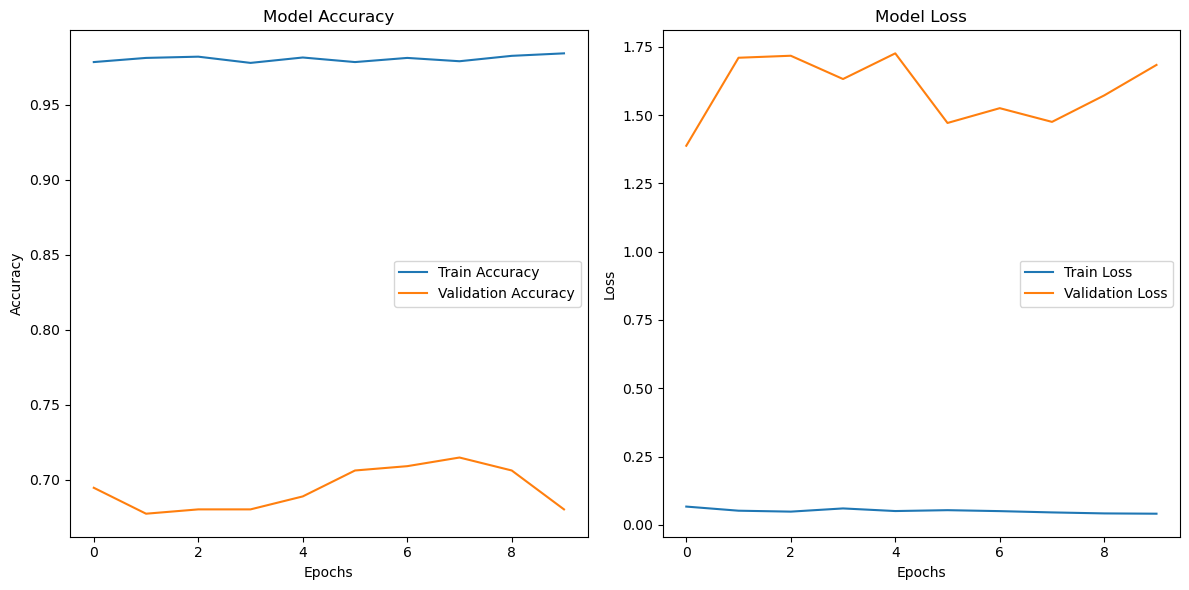

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Validation Accuracy: 0.3112/n


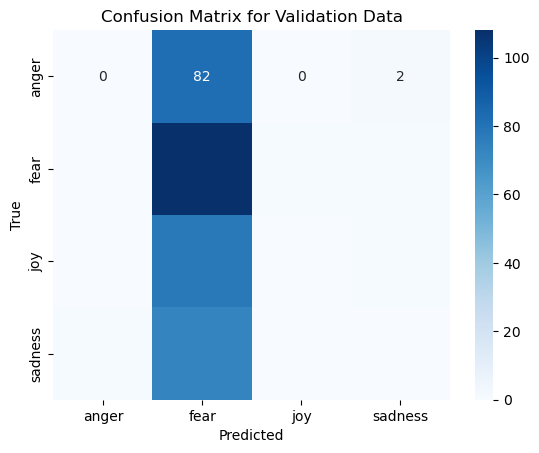

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test Accuracy: 0.3195/n


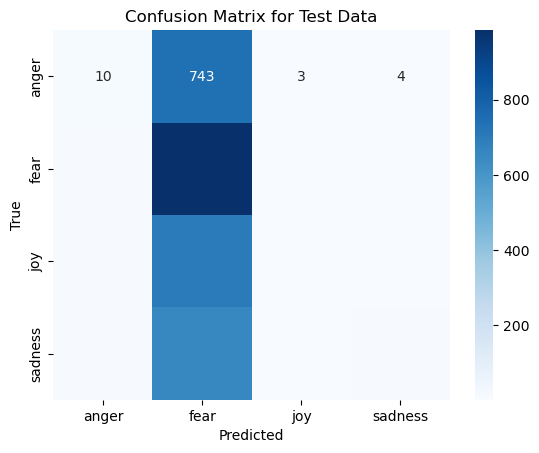

In [60]:
# Model  accuracies and loss
def model_evaluation(model, history):
    model_accuracy_and_loss(history)# Predict on Test data
    # Predict on Test data
    make_prediction(model, X_val_pad, y_val_encoded, "Validation")
    make_prediction(model, X_test_pad, y_test_encoded, "Test")
    
model_evaluation(model_3, history_3)

#### This performance in the model 3 dropped very badly so we can not trade off computational resouces with the performace

## Model 4: A LSTM with GRU Embedings with regularization and drop out to prevent over fitting

In [81]:
l2_rate = 0.001  # L2 regularization strength# Build a deeper and more complex model with improvements
model_4 = Sequential()

# Embedding Layer
model_4.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# Bidirectional LSTM Layer
model_4.add(Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(l2_rate))))
model_4.add(Dropout(0.4))  # Increased dropout to prevent overfitting

# GRU Layer
model_4.add(GRU(32, dropout=0.3, kernel_regularizer=l2(l2_rate)))  # Decreased units for less complexity

# Dense Hidden Layer with Batch Normalization
model_4.add(Dense(32, activation='relu', kernel_regularizer=l2(l2_rate)))  # Reduced number of neurons
model_4.add(BatchNormalization())

# Dropout after Dense layer
model_4.add(Dropout(0.4))  # Increased dropout to reduce overfitting

# Output Layer (4 classes)
model_4.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification

# Compile the model
model_4.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [106]:
# Display the model summary
model_4.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 15, 100)             │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 15, 64)              │          34,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,634,190 (6.23 MB)

 Trainable params: 544,708 (2.08 MB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 1,089,418 (4.16 MB)

In [83]:
# Train the model (use early stopping callback)
history_4 = model_4.fit(X_train_pad, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_val_pad, y_val_encoded))


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.2790 - loss: 1.7008 - val_accuracy: 0.3170 - val_loss: 1.5675
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5197 - loss: 1.3296 - val_accuracy: 0.5937 - val_loss: 1.3321
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7806 - loss: 0.6978 - val_accuracy: 0.6225 - val_loss: 1.0710
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8847 - loss: 0.4654 - val_accuracy: 0.7233 - val_loss: 0.8899
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9401 - loss: 0.3227 - val_accuracy: 0.7349 - val_loss: 0.9368
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9579 - loss: 0.2606 - val_accuracy: 0.7464 - val_loss: 0.9352
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9679 - loss: 0.2140 - val_accuracy: 0.7464 - val_loss: 1.0098
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9772 - loss: 0.1966 - val_acc

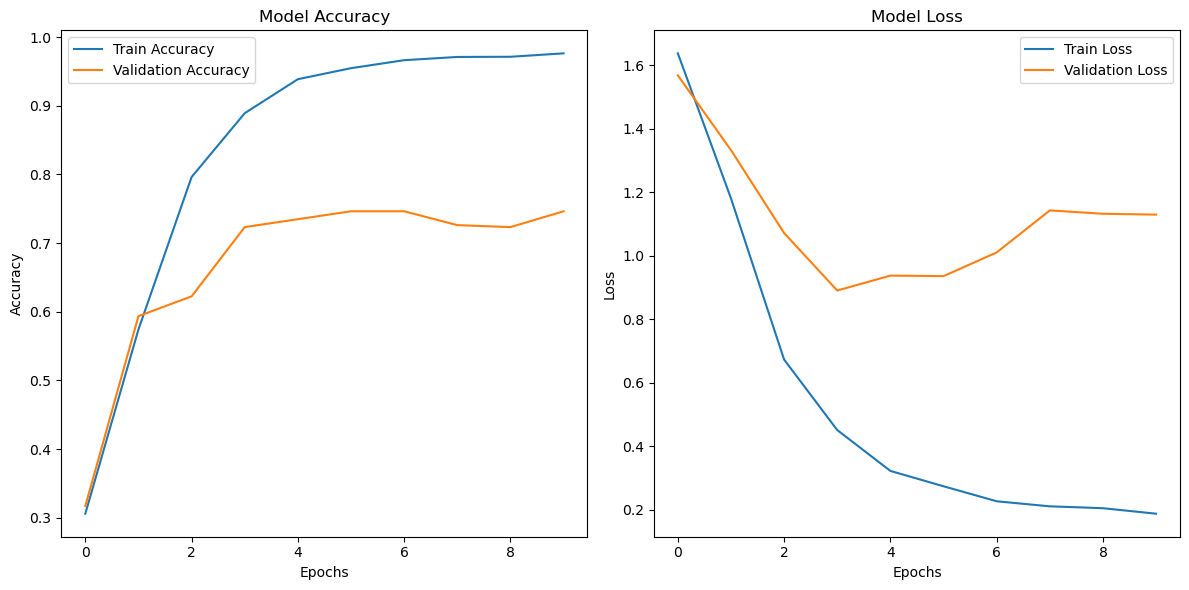

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Validation Accuracy: 0.7464/n


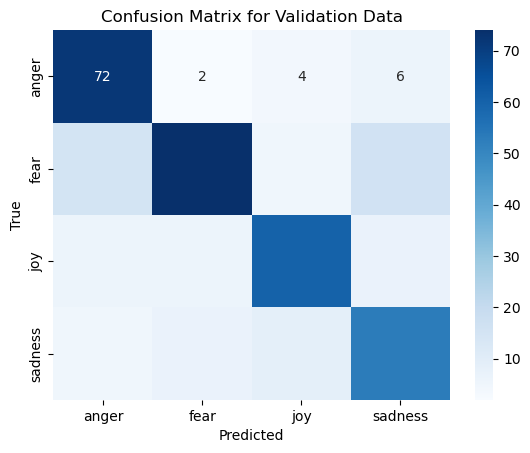

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test Accuracy: 0.7327/n


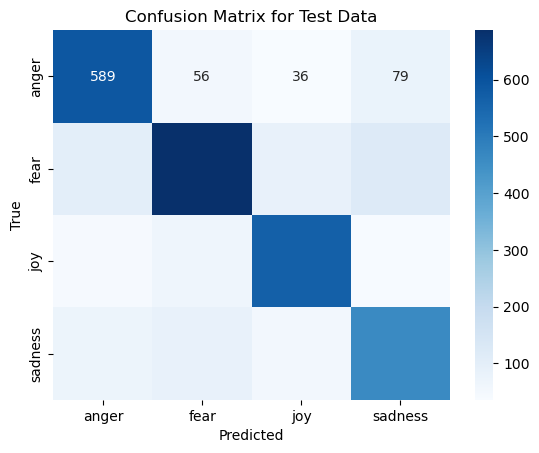

In [84]:
model_evaluation(model_4, history_4)

In [100]:
# Build a new model with a different architecture
model_5 = Sequential()

# Embedding Layer
model_5.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# Convolutional Layer
model_5.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_rate)))
model_5.add(MaxPooling1D(pool_size=2))  # Pooling to reduce dimensionality

# Another Convolutional Layer
model_5.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_rate)))
model_5.add(MaxPooling1D(pool_size=2))  # Pooling again

# Bidirectional LSTM Layer (Capturing sequence dependencies)
model_5.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(l2_rate))))
model_5.add(Dropout(0.4))  # Dropout to prevent overfitting

# GRU Layer (Capturing sequence dependencies, returning sequences for GlobalMaxPooling1D)
model_5.add(GRU(32, return_sequences=True, dropout=0.3, kernel_regularizer=l2(l2_rate)))  # return_sequences=True

# Global Max Pooling to reduce the dimensions before the dense layers
model_5.add(GlobalMaxPooling1D())

# Dense Hidden Layer with Batch Normalization
model_5.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_rate)))  # Adjusted number of neurons
model_5.add(BatchNormalization())

# Dropout after Dense layer
model_5.add(Dropout(0.4))  # Dropout to prevent overfitting

# Output Layer (Softmax for multi-class classification)
model_5.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification

# Compile the model
model_5.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [105]:
# Summary of the model architecture
model_5.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)             │ (None, 15, 100)             │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 13, 128)             │          38,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 4, 128)              │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 2, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ (None, 2, 32)               │          15,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_4               │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,114,158 (8.06 MB)

 Trainable params: 704,676 (2.69 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 1,409,354 (5.38 MB)

In [102]:
# Train the model (use early stopping callback)
history_5 = model_5.fit(X_train_pad, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_val_pad, y_val_encoded))


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.2812 - loss: 2.0126 - val_accuracy: 0.3170 - val_loss: 1.7921
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4528 - loss: 1.6024 - val_accuracy: 0.3372 - val_loss: 1.6094
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8110 - loss: 0.8527 - val_accuracy: 0.6657 - val_loss: 1.3229
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9573 - loss: 0.4680 - val_accuracy: 0.7061 - val_loss: 1.0506
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9740 - loss: 0.3673 - val_accuracy: 0.7378 - val_loss: 1.0028
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9784 - loss: 0.3399 - val_accuracy: 0.7320 - val_loss: 1.0565
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9787 - loss: 0.3022 - val_accuracy: 0.7493 - val_loss: 1.1062
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9845 - loss: 0.2712 - val_acc

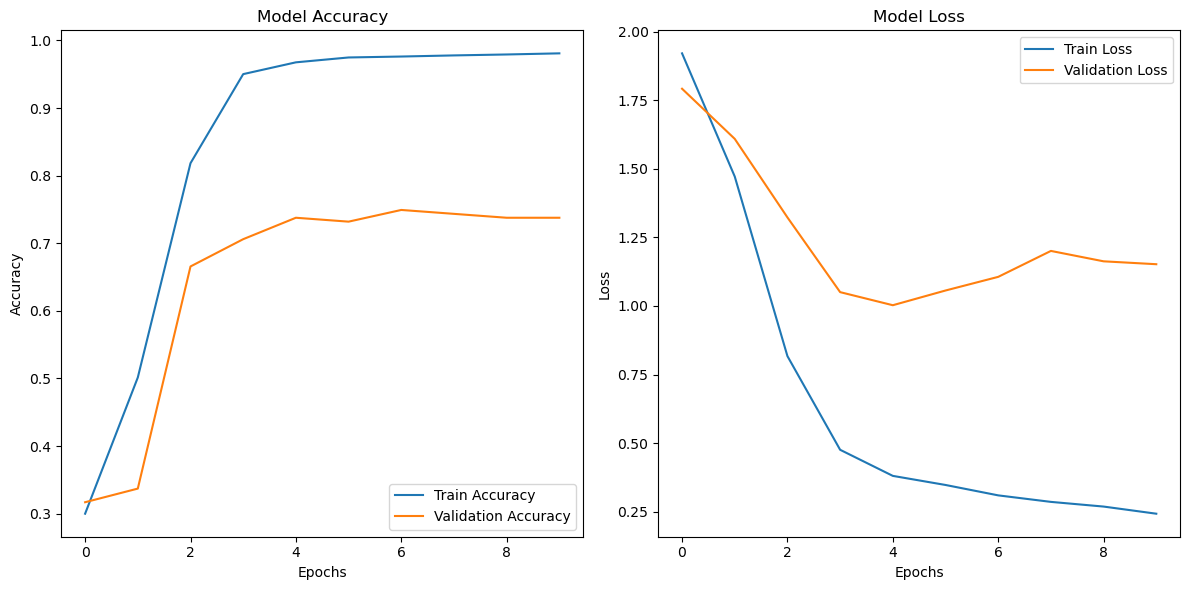

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Validation Accuracy: 0.7378/n


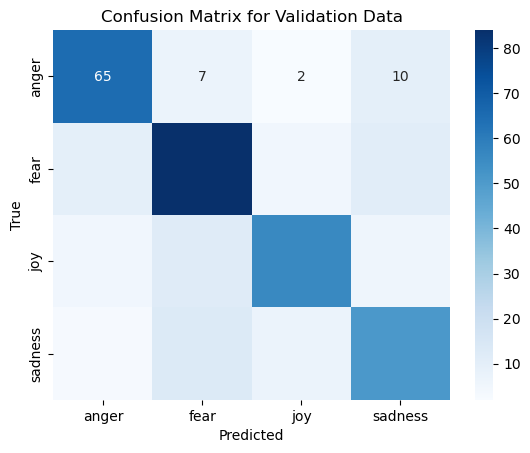

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Accuracy: 0.7327/n


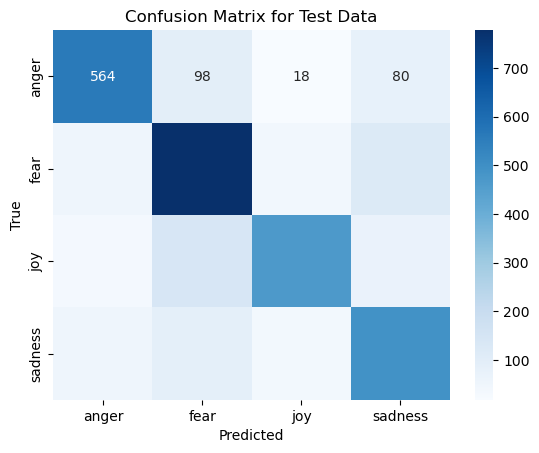

In [104]:
model_evaluation(model_5, history_5)

# Conclusion
## Best Model

To evaluate and compare the performance of the models (Model 1, Model 3, Model 4, and Model 5), we will analyze them based on several metrics such as accuracy, loss, model complexity (number of parameters), and overfitting behavior (training vs validation accuracy).

| **Model**   | **Training Accuracy** | **Validation Accuracy** | **Training Loss** | **Validation Loss** | **Total Parameters** | **Trainable Parameters** | **Optimizer Parameters** |
|-------------|-----------------------|-------------------------|-------------------|---------------------|----------------------|--------------------------|--------------------------|
| **Model 1** | 98.16%                | 73.49%                  | 0.0625            | 0.9002              | 2,416,494            | 805,412                  | 1,610,826                |
| **Model 3** | 98.61%                | 68.01%                  | 0.0403            | 1.6837              | 542,500              | 542,500                  | N/A                      |
| **Model 4** | 98.07%                | 74.64%                  | 0.1785            | 1.1289              | 1,634,190            | 544,708                  | 1,089,418                |
| **Model 5** | 98.21%                | 73.78%                  | 0.2388            | 1.1523              | 2,114,158            | 704,676                  | 1,409,354                |


Best Model Selection
Based on the comparison, Model 4 appears to be the best performing model, as it achieves the following:

Best Validation Accuracy: With 74.64% validation accuracy, it outperforms all other models.
Lower Overfitting: The gap between training and validation loss is smaller than Model 5 and Model 3, indicating it generalizes better to unseen data.
Moderate Complexity: With 1.63 million parameters, it strikes a good balance between model complexity and performance. It is not too complex to lead to overfitting, nor too simple to underperform.

### Why Model 4 is the Best:
Higher Validation Accuracy: It achieves the highest validation accuracy of all models, which is the most critical metric for real-world applications.

Reduced Overfitting: The lower gap between training and validation loss suggests that Model 4 generalizes better than Models 5 and 1, which overfit more severely.

Optimal Complexity: The model has a reasonable number of parameters, which means it’s powerful enough to capture the necessary patterns without being excessively complex.

Better Regularization: Dropout and L2 regularization help to prevent overfitting, leading to improved validation performance.

## Model 4 on test and validation dataset

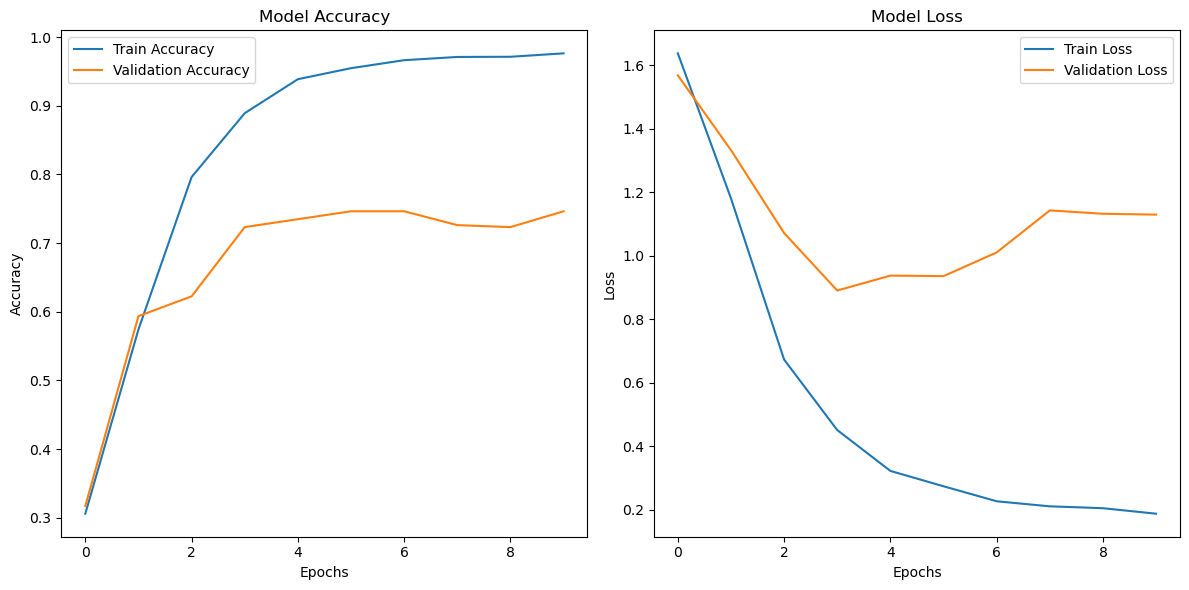

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Validation Accuracy: 0.7464/n


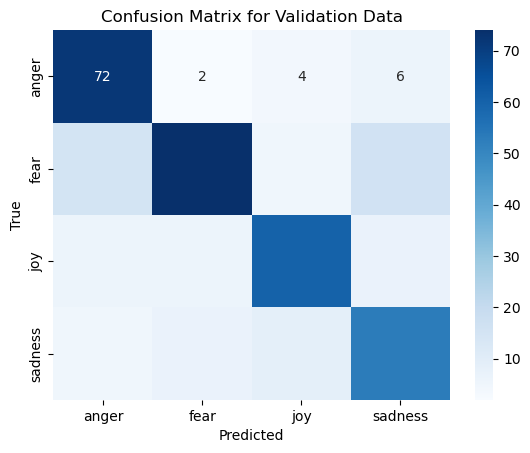

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test Accuracy: 0.7327/n


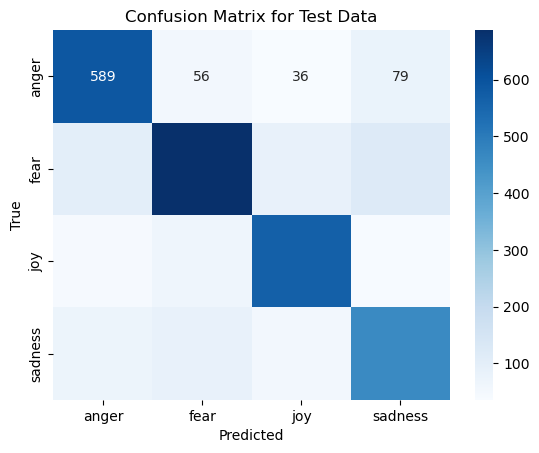

In [108]:
model_evaluation(model_4, history_4)